In [14]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from ae_model import Autoencoder
from sklearn.decomposition import PCA

The autoencoder model is pre-trained from previous project: [interactive_denoiser](https://github.com/ShlomiRex/interactive_denoiser)

Its simple autoencoder with 3 CNN layers (and the decoder is the reverse of the encoder).

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [16]:
# Load the pretrained model
model = Autoencoder(128)
model.load_state_dict(torch.load("ae_model.pth", map_location=device))

# Set the model to evaluation mode
model.to(device)
model.eval()

C:\Users\Shlomi\AppData\Local\Temp\ipykernel_33564\3187823911.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("ae_model.pth", map_locati

Autoencoder(
  (enc_conv1): Conv2d(1, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (enc_relu1): ReLU()
  (enc_conv2): Conv2d(512, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (enc_relu2): ReLU()
  (enc_conv3): Conv2d(256, 128, kernel_size=(7, 7), stride=(1, 1))
  (enc_linear): Linear(in_features=128, out_features=128, bias=True)
  (dec_linear): Linear(in_features=128, out_features=128, bias=True)
  (dec_conv1): ConvTranspose2d(128, 256, kernel_size=(7, 7), stride=(1, 1))
  (dec_relu1): ReLU()
  (dec_conv2): ConvTranspose2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (dec_relu2): ReLU()
  (dec_conv3): ConvTranspose2d(512, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (dec_tanh): Tanh()
)

In [17]:
dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

batch_size = 64
dataset_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
print(f"Dataset size: {len(dataset)}")

Dataset size: 10000


# View latent space of autoencoder

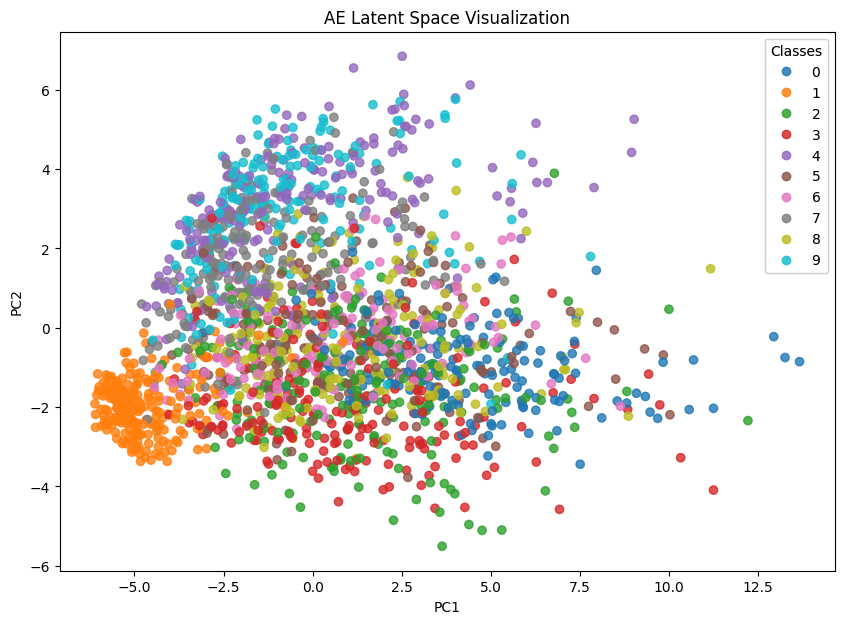

In [18]:
# Extract latent vectors from a subset of the test set
def extract_latent_vectors(loader, num_samples=500):
    latent_vectors = []
    labels = []
    count = 0

    with torch.no_grad():
        for images, targets in loader:
            images = images.to(device)
            latent = model.encode(images).view(images.size(0), -1)  # Flatten latent space

            latent_vectors.append(latent.cpu())
            labels.append(targets)
            count += images.size(0)

            if count >= num_samples:  # Stop after collecting enough samples
                break

    latent_vectors = torch.cat(latent_vectors, dim=0)[:num_samples]
    labels = torch.cat(labels, dim=0)[:num_samples]
    return latent_vectors.numpy(), labels.numpy()

# Visualize the latent space
def plot_latent_space(latent_2d, labels):
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111)

    scatter = ax.scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels, cmap='tab10', alpha=0.8)
    ax.set_title('AE Latent Space Visualization')
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')

    # Add legend
    legend = ax.legend(*scatter.legend_elements(), title="Classes", loc="upper right")
    ax.add_artist(legend)

    plt.show()


num_samples = 2_000
latent_vectors, labels = extract_latent_vectors(dataset_loader, num_samples)

# Reduce dimensionality to 2D
pca = PCA(n_components=2)
latent_2d = pca.fit_transform(latent_vectors)
plot_latent_space(latent_2d, labels)

The PCA analysis tells us the model is not learning the latent space well.

# Sample random latent vectors

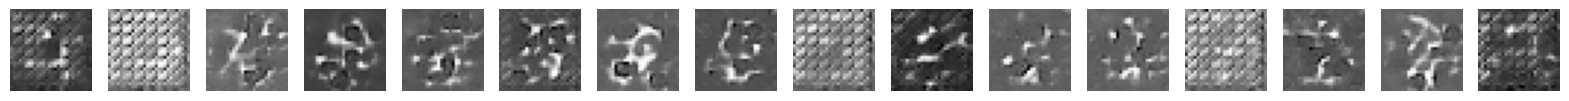

In [19]:
# Sample random latent vectors and decode them
n_samples = 16
latent_samples = torch.randn(n_samples, 128).to(device)
reconstructed_samples = model.decode(latent_samples).cpu()

# Visualize the reconstructed samples
fig, axes = plt.subplots(1, n_samples, figsize=(20, 2))

for i in range(n_samples):
    axes[i].imshow(reconstructed_samples[i].view(28, 28).detach().numpy(), cmap='gray')
    axes[i].axis('off')

plt.show()

## This is not VAE. This is AE. Every image is mapped to fixed latent vector. We can't interpolate between latent vectors. This is where Variational Autoencoder comes into play.

<img src="img.jpg" alt="Drawing" style="width: 800px;"/>

In [20]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from sklearn.decomposition import PCA
import torch.nn as nn
from einops import rearrange
from torchsummary import summary
import torch.optim as optim
from model import VariationalAutoencoder

Define the VAE model. All of the layers are exactly the same as the autoencoder model, except the latent space is now a distribution.

I also added fc_mu and fc_logvar layers. These layers are responsible for generating the latent space distribution.

We added sample method which takes in mean and logvar and samples from the distribution.

In [21]:
def loss_function(x, x_hat, mean, log_var):
    # Reconstruction loss
    # recon_loss = nn.MSELoss()(x_hat, x)
    recon_loss = nn.BCELoss(reduction='sum')(x_hat, x)

    # KL divergence loss
    kl_loss = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())

    return recon_loss + kl_loss, recon_loss, kl_loss

In [22]:
input_dim = 1 * 28 * 28
hidden_dim = 400
latent_dim = 200

vae = VariationalAutoencoder(input_dim, hidden_dim, latent_dim, device)
vae.to(device)

summary(vae, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 400]         314,000
              ReLU-2                  [-1, 400]               0
            Linear-3                  [-1, 400]         160,400
              ReLU-4                  [-1, 400]               0
            Linear-5                  [-1, 200]          80,200
            Linear-6                  [-1, 200]          80,200
            Linear-7                  [-1, 400]          80,400
              ReLU-8                  [-1, 400]               0
            Linear-9                  [-1, 400]         160,400
             ReLU-10                  [-1, 400]               0
           Linear-11                  [-1, 784]         314,384
Total params: 1,189,984
Trainable params: 1,189,984
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forw

The VAE model has similar parameter count as the base autoencoder model.

The base AE model has 5,614,465 parameters.

Here we have 1.189M parameters, which is significantly less.

# Without training, see the VAE reconstruction

In [23]:
del model # We don't need the AE model anymore
model = None
model = vae

lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)

In [24]:
# Transformations: Normalize and convert to tensor
# transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
transform = transforms.Compose([transforms.ToTensor()])  # See what happens if we dont normalize

# Load dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# DataLoader
batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## See what happens when we try to reconstruct without training.

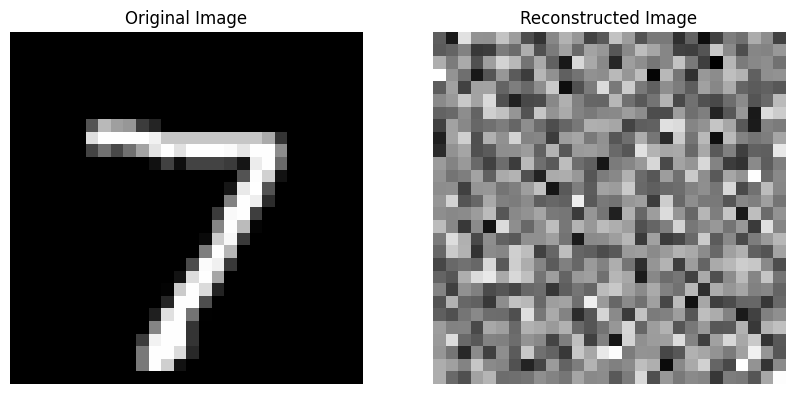

In [25]:
# Plot a single image and the reconstructed image
model.eval()
with torch.no_grad():
    single_image, _ = test_dataset[0]
    single_image = single_image.unsqueeze(0).to(device)  # Add batch dimension and move to device

    reconstructed, _, _ = model(single_image)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(single_image.cpu().view(28, 28), cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(reconstructed.cpu().view(28, 28), cmap='gray')
plt.title('Reconstructed Image')
plt.axis('off')
plt.show()


The model is not trained so its not surprising that the reconstruction is bad.

# Train the model on MNIST dataset

In [26]:
from tqdm import tqdm
import cv2
import numpy as np

In [27]:
# Training loop
num_epochs = 20

loss_history = []
kl_divergence_history = []
recon_loss_history = []

for epoch in range(num_epochs):
    model.train()

    overall_loss = 0

    # Use tqdm for progress tracking
    with tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]") as t:
        for images, _ in t:
            images = images.to(device)

            optimizer.zero_grad() # Zero gradients before performing a backward pass

            # Forward pass
            x_hat, mean, log_var = model(images)

            # Calculate loss
            loss, recon_loss, kl_loss = loss_function(images, x_hat, mean, log_var)

            # Add all three losses to history
            loss_history.append(loss.item())
            recon_loss_history.append(recon_loss.item())
            kl_divergence_history.append(kl_loss.item())

            overall_loss += loss.item()

            # Propagate the loss backward
            loss.backward() # Compute gradients (of KL + recon losses)
            optimizer.step() # Adjust weights of the model

            # # Update tqdm description with current loss
            t.set_postfix(loss=loss.item(), recon_loss=recon_loss.item(), kl_loss=kl_loss.item())

    print(f"Epoch [{epoch+1}/{num_epochs}], Recon Loss: {np.mean(recon_loss_history).item():.4f}, KL Loss: {np.mean(kl_divergence_history).item():.4f}")
    print("Average loss: ", overall_loss / len(train_loader))





Epoch [1/20]: 100%|██████████| 3750/3750 [00:28<00:00, 130.26it/s, kl_loss=270, loss=2.26e+3, recon_loss=1.99e+3]


Epoch [1/20], Recon Loss: 2315.0355, KL Loss: 205.9074
Average loss:  2520.9428122070312


Epoch [2/20]: 100%|██████████| 3750/3750 [00:29<00:00, 127.71it/s, kl_loss=259, loss=1.68e+3, recon_loss=1.42e+3]


Epoch [2/20], Recon Loss: 2031.5645, KL Loss: 228.6711
Average loss:  1999.528333203125


Epoch [3/20]: 100%|██████████| 3750/3750 [00:29<00:00, 126.19it/s, kl_loss=261, loss=1.85e+3, recon_loss=1.59e+3]


Epoch [3/20], Recon Loss: 1903.8470, KL Loss: 239.7608
Average loss:  1910.3521885091145


Epoch [4/20]: 100%|██████████| 3750/3750 [00:29<00:00, 127.28it/s, kl_loss=266, loss=1.82e+3, recon_loss=1.55e+3]


Epoch [4/20], Recon Loss: 1827.6371, KL Loss: 246.8619
Average loss:  1867.1726643554687


Epoch [5/20]: 100%|██████████| 3750/3750 [00:28<00:00, 129.56it/s, kl_loss=260, loss=1.73e+3, recon_loss=1.47e+3]


Epoch [5/20], Recon Loss: 1772.1302, KL Loss: 252.2661
Average loss:  1823.9853955729166


Epoch [6/20]: 100%|██████████| 3750/3750 [00:29<00:00, 125.98it/s, kl_loss=255, loss=1.98e+3, recon_loss=1.72e+3]


Epoch [6/20], Recon Loss: 1731.1489, KL Loss: 256.4815
Average loss:  1803.8009482747395


Epoch [7/20]: 100%|██████████| 3750/3750 [00:29<00:00, 128.21it/s, kl_loss=270, loss=1.65e+3, recon_loss=1.38e+3]


Epoch [7/20], Recon Loss: 1699.8278, KL Loss: 259.8055
Average loss:  1791.650666764323


Epoch [8/20]: 100%|██████████| 3750/3750 [00:29<00:00, 129.29it/s, kl_loss=296, loss=1.79e+3, recon_loss=1.49e+3]


Epoch [8/20], Recon Loss: 1674.9251, KL Loss: 262.5026
Average loss:  1781.988777701823


Epoch [9/20]: 100%|██████████| 3750/3750 [00:29<00:00, 125.74it/s, kl_loss=276, loss=1.64e+3, recon_loss=1.37e+3]


Epoch [9/20], Recon Loss: 1654.5879, KL Loss: 264.7500
Average loss:  1774.6194905924478


Epoch [10/20]: 100%|██████████| 3750/3750 [00:30<00:00, 124.78it/s, kl_loss=284, loss=1.45e+3, recon_loss=1.17e+3]


Epoch [10/20], Recon Loss: 1637.5353, KL Loss: 266.5923
Average loss:  1767.2353169921876


Epoch [11/20]: 100%|██████████| 3750/3750 [00:29<00:00, 126.20it/s, kl_loss=274, loss=1.71e+3, recon_loss=1.44e+3]


Epoch [11/20], Recon Loss: 1622.8931, KL Loss: 268.2777
Average loss:  1761.6025646484375


Epoch [12/20]: 100%|██████████| 3750/3750 [00:31<00:00, 119.39it/s, kl_loss=277, loss=1.89e+3, recon_loss=1.61e+3]


Epoch [12/20], Recon Loss: 1610.1789, KL Loss: 269.6916
Average loss:  1755.5676451171876


Epoch [13/20]: 100%|██████████| 3750/3750 [00:29<00:00, 125.52it/s, kl_loss=287, loss=1.96e+3, recon_loss=1.68e+3]


Epoch [13/20], Recon Loss: 1599.0341, KL Loss: 270.9901
Average loss:  1751.8684324869791


Epoch [14/20]: 100%|██████████| 3750/3750 [00:31<00:00, 120.49it/s, kl_loss=292, loss=1.76e+3, recon_loss=1.47e+3]


Epoch [14/20], Recon Loss: 1589.1621, KL Loss: 272.1351
Average loss:  1747.846051171875


Epoch [15/20]: 100%|██████████| 3750/3750 [00:29<00:00, 127.88it/s, kl_loss=277, loss=1.78e+3, recon_loss=1.5e+3] 


Epoch [15/20], Recon Loss: 1580.3485, KL Loss: 273.1684
Average loss:  1744.5922174479167


Epoch [16/20]: 100%|██████████| 3750/3750 [00:29<00:00, 125.33it/s, kl_loss=297, loss=1.8e+3, recon_loss=1.5e+3]  


Epoch [16/20], Recon Loss: 1572.3726, KL Loss: 274.1004
Average loss:  1740.814502376302


Epoch [17/20]: 100%|██████████| 3750/3750 [00:30<00:00, 124.00it/s, kl_loss=293, loss=1.83e+3, recon_loss=1.54e+3]


Epoch [17/20], Recon Loss: 1565.1514, KL Loss: 274.9450
Average loss:  1738.0703203776043


Epoch [18/20]: 100%|██████████| 3750/3750 [00:29<00:00, 126.75it/s, kl_loss=293, loss=1.75e+3, recon_loss=1.45e+3]


Epoch [18/20], Recon Loss: 1558.5616, KL Loss: 275.7200
Average loss:  1735.4309462890626


Epoch [19/20]: 100%|██████████| 3750/3750 [00:30<00:00, 123.73it/s, kl_loss=289, loss=1.75e+3, recon_loss=1.46e+3]


Epoch [19/20], Recon Loss: 1552.5269, KL Loss: 276.4522
Average loss:  1733.5324905273437


Epoch [20/20]: 100%|██████████| 3750/3750 [00:29<00:00, 125.49it/s, kl_loss=279, loss=1.61e+3, recon_loss=1.33e+3]


Epoch [20/20], Recon Loss: 1546.9663, KL Loss: 277.1046
Average loss:  1730.8161153645833


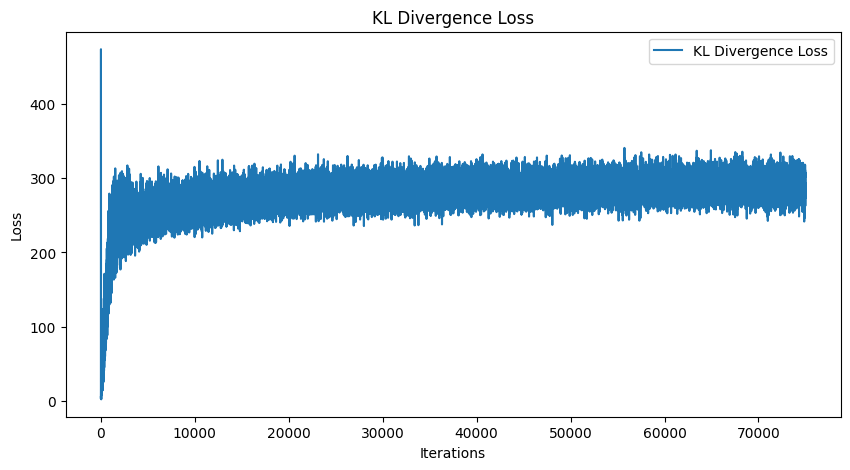

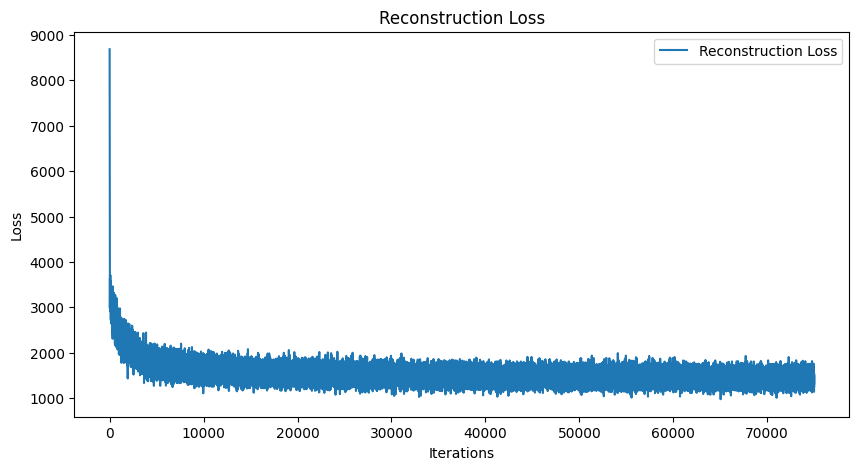

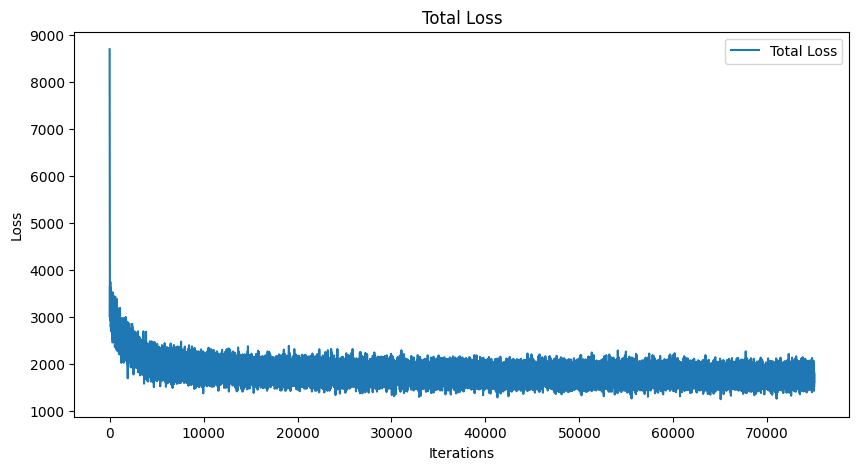

In [28]:
# Plot the log of the loss history, KL divergence in one graph and reconstruction loss in another.

plt.figure(figsize=(10, 5))
plt.plot(kl_divergence_history, label='KL Divergence Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('KL Divergence Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(recon_loss_history, label='Reconstruction Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Reconstruction Loss')
plt.legend()
plt.show()

# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(loss_history, label='Total Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Total Loss')
plt.legend()
plt.show()


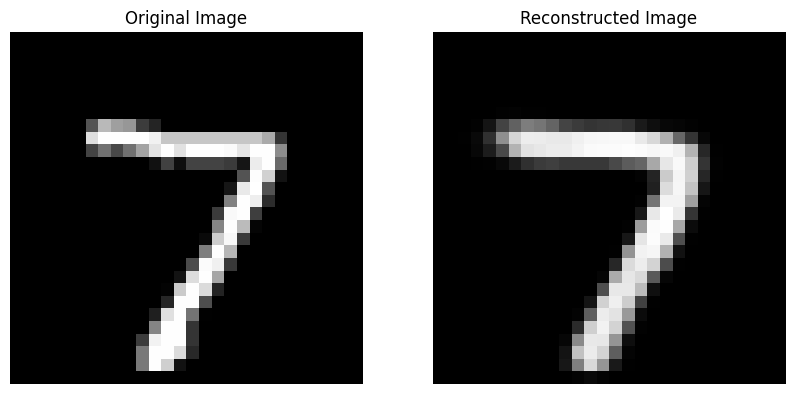

In [29]:
# Plot a single image and the reconstructed image
model.eval()
with torch.no_grad():
    single_image, _ = test_dataset[0]
    single_image = single_image.unsqueeze(0).to(device)  # Add batch dimension and move to device

    reconstructed, _, _ = model(single_image)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(single_image.cpu().view(28, 28), cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(reconstructed.cpu().view(28, 28), cmap='gray')
plt.title('Reconstructed Image')
plt.axis('off')
plt.show()


# Visualize latent vector reconstruction

torch.Size([8, 1, 28, 28])


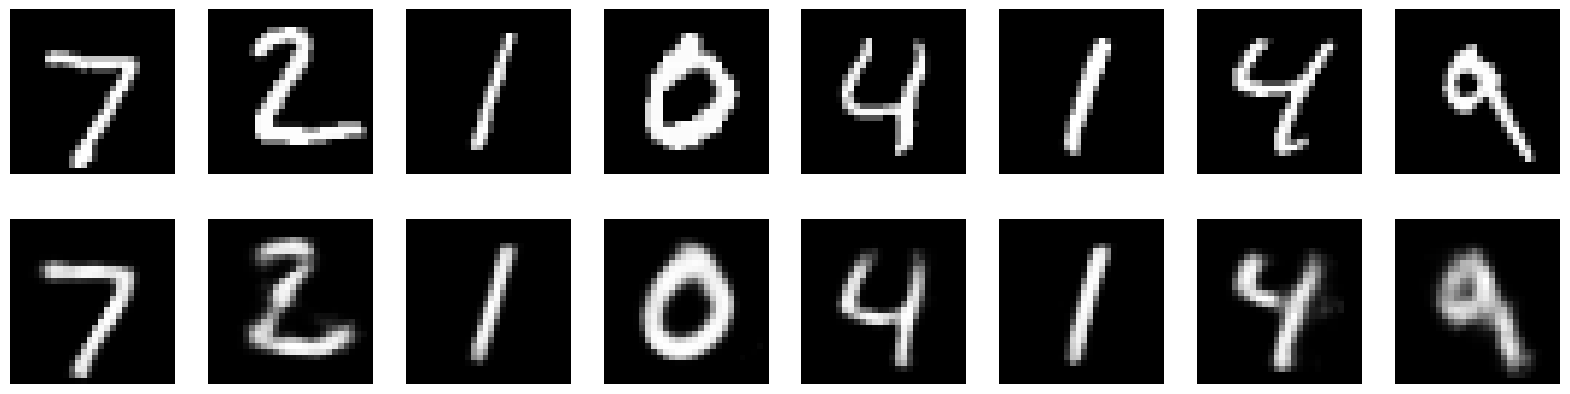

In [30]:
# Plot 8 images (original image) and to their right plot the reconstructed image
model.eval()
with torch.no_grad():
    images, _ = next(iter(test_loader))
    images = images[:8].to(device)

    outputs, _, _ = model(images)

    images = images.cpu()
    outputs = outputs.cpu()

    print(outputs.shape)

    fig, axes = plt.subplots(2, 8, figsize=(20, 5))
    for i in range(8):
        axes[0, i].imshow(images[i].view(28, 28), cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].imshow(outputs[i].view(28, 28), cmap='gray')
        axes[1, i].axis('off')

    plt.show()

# Check if the model can denoise without explicitly training on noise data

In [31]:
def add_gaussian_noise(images, mean=0.0, std=0.1):
    """
    Adds Gaussian noise to a batch of images.
    
    Parameters:
    images (torch.Tensor): Batch of images.
    mean (float): Mean of the Gaussian noise.
    std (float): Standard deviation of the Gaussian noise.
    
    Returns:
    torch.Tensor: Noisy images.
    """
    noise = torch.randn_like(images) * std + mean
    noisy_images = images + noise
    noisy_images = torch.clip(noisy_images, 0., 1.)
    return noisy_images

def add_salt_and_pepper_noise(images, salt_prob=0.1, pepper_prob=0.1):
    """
    Adds salt and pepper noise to a batch of images.
    
    Parameters:
    images (torch.Tensor): Batch of images.
    salt_prob (float): Probability of adding salt noise.
    pepper_prob (float): Probability of adding pepper noise.
    
    Returns:
    torch.Tensor: Noisy images.
    """
    noisy_images = images.clone()
    salt_mask = torch.rand_like(images) < salt_prob
    pepper_mask = torch.rand_like(images) < pepper_prob
    noisy_images[salt_mask] = 1.0
    noisy_images[pepper_mask] = 0.0
    return noisy_images

def sample_value(mean, std):
    value = torch.randn(1) * std + mean
    return value.clamp(0, 1).item()

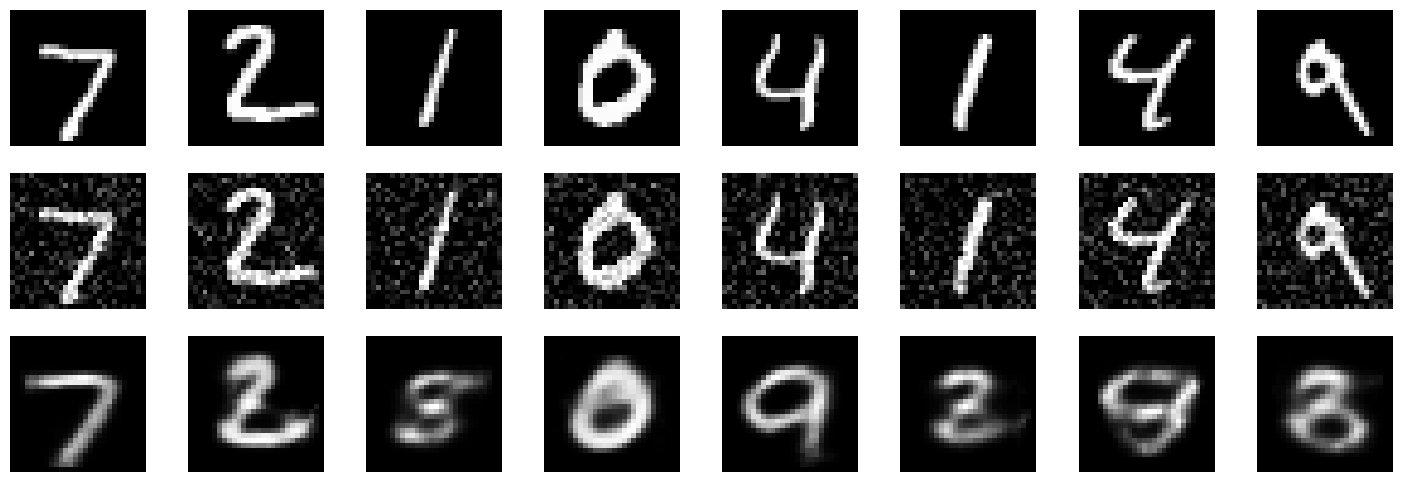

In [32]:
# Take 8 images from the test set, add noise and reconstruct
images, _ = next(iter(test_loader))
images = images[:8]

# Add Gaussian noise
noisy_images = add_gaussian_noise(images, std=sample_value(0.2, 0.2))
noisy_images = noisy_images.to(device)

# Reconstruct the images
model.eval()
with torch.no_grad():
    reconstructed, _, _ = model(noisy_images)
    # Plot original, noisy and reconstructed images
    fig, axes = plt.subplots(3, 8, figsize=(18, 6))
    for images, row in zip([images, noisy_images, reconstructed], axes):
        for img, ax in zip(images, row):
            img = img.to('cpu')
            ax.imshow(img.squeeze(), cmap='gray')
            ax.axis('off')
    plt.show()

Surprisingly, the model can denoise the images without being trained on noisy data.

# Sample from latent space

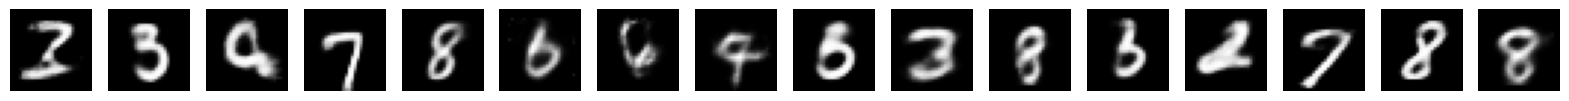

In [33]:
# Sample random latent vectors from a standard normal distribution
n_samples = 16

# Decode the latent vectors to generate images
vae.eval()
with torch.no_grad():
    # Epsilon is between 0 and 1, this is how we sample random latent vector
    epsilon = torch.randn(n_samples, latent_dim).to(device)
    generated_images = vae.decode(epsilon).cpu()

# Visualize the generated images
fig, axes = plt.subplots(1, n_samples, figsize=(20, 2))
for i in range(n_samples):
    axes[i].imshow(generated_images[i].view(28, 28), cmap='gray')
    axes[i].axis('off')

plt.show()

# Train on noisy data

In [34]:
# Training loop
num_epochs = 20

loss_history = []
kl_divergence_history = []
recon_loss_history = []

for epoch in range(num_epochs):
    model.train()

    overall_loss = 0

    # Use tqdm for progress tracking
    with tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]") as t:
        for images, _ in t:
            images = images.to(device)

            # Add gaussian noise
            images = add_gaussian_noise(images, std=sample_value(0.2, 0.2))

            optimizer.zero_grad() # Zero gradients before performing a backward pass

            # Forward pass
            x_hat, mean, log_var = model(images)

            # Calculate loss
            loss, recon_loss, kl_loss = loss_function(images, x_hat, mean, log_var)

            # Add all three losses to history
            loss_history.append(loss.item())
            recon_loss_history.append(recon_loss.item())
            kl_divergence_history.append(kl_loss.item())

            overall_loss += loss.item()

            # Propagate the loss backward
            loss.backward() # Compute gradients (of KL + recon losses)
            optimizer.step() # Adjust weights of the model

            # # Update tqdm description with current loss
            t.set_postfix(loss=loss.item(), recon_loss=recon_loss.item(), kl_loss=kl_loss.item())

    print(f"Epoch [{epoch+1}/{num_epochs}], Recon Loss: {np.mean(recon_loss_history).item():.4f}, KL Loss: {np.mean(kl_divergence_history).item():.4f}")
    print("Average loss: ", overall_loss / len(train_loader))


Epoch [1/20]: 100%|██████████| 3750/3750 [00:28<00:00, 133.51it/s, kl_loss=171, loss=7.29e+3, recon_loss=7.12e+3]  


Epoch [1/20], Recon Loss: 4599.4515, KL Loss: 214.5257
Average loss:  4813.977207128906


Epoch [2/20]: 100%|██████████| 3750/3750 [00:28<00:00, 133.28it/s, kl_loss=229, loss=4.04e+3, recon_loss=3.81e+3]


Epoch [2/20], Recon Loss: 4502.1512, KL Loss: 216.0624
Average loss:  4622.449991699219


Epoch [3/20]: 100%|██████████| 3750/3750 [00:29<00:00, 127.74it/s, kl_loss=250, loss=3.58e+3, recon_loss=3328.75]


Epoch [3/20], Recon Loss: 4451.0674, KL Loss: 218.6064
Average loss:  4572.594001041667


Epoch [4/20]: 100%|██████████| 3750/3750 [00:29<00:00, 125.94it/s, kl_loss=250, loss=3.08e+3, recon_loss=2.83e+3]


Epoch [4/20], Recon Loss: 4423.2988, KL Loss: 220.5279
Average loss:  4566.285672070312


Epoch [5/20]: 100%|██████████| 3750/3750 [00:27<00:00, 134.16it/s, kl_loss=217, loss=4.72e+3, recon_loss=4.5e+3] 


Epoch [5/20], Recon Loss: 4402.8869, KL Loss: 221.9651
Average loss:  4548.953580729167


Epoch [6/20]: 100%|██████████| 3750/3750 [00:29<00:00, 128.70it/s, kl_loss=246, loss=3.7e+3, recon_loss=3.46e+3] 


Epoch [6/20], Recon Loss: 4381.8361, KL Loss: 223.4092
Average loss:  4507.211445540364


Epoch [7/20]: 100%|██████████| 3750/3750 [00:28<00:00, 129.77it/s, kl_loss=197, loss=5.46e+3, recon_loss=5.26e+3]


Epoch [7/20], Recon Loss: 4365.8894, KL Loss: 224.6552
Average loss:  4502.340226334635


Epoch [8/20]: 100%|██████████| 3750/3750 [00:29<00:00, 129.13it/s, kl_loss=191, loss=5.69e+3, recon_loss=5.5e+3] 


Epoch [8/20], Recon Loss: 4356.3297, KL Loss: 225.5824
Average loss:  4521.484595996094


Epoch [9/20]: 100%|██████████| 3750/3750 [00:29<00:00, 126.47it/s, kl_loss=348, loss=1.9e+3, recon_loss=1.55e+3] 


Epoch [9/20], Recon Loss: 4347.7822, KL Loss: 226.4236
Average loss:  4512.55550546875


Epoch [10/20]: 100%|██████████| 3750/3750 [00:29<00:00, 126.98it/s, kl_loss=295, loss=1.84e+3, recon_loss=1.54e+3]


Epoch [10/20], Recon Loss: 4337.0936, KL Loss: 227.2905
Average loss:  4475.989298111979


Epoch [11/20]: 100%|██████████| 3750/3750 [00:29<00:00, 127.12it/s, kl_loss=257, loss=3.23e+3, recon_loss=2.97e+3]


Epoch [11/20], Recon Loss: 4327.3559, KL Loss: 228.0461
Average loss:  4465.580416113281


Epoch [12/20]: 100%|██████████| 3750/3750 [00:31<00:00, 119.06it/s, kl_loss=251, loss=3.46e+3, recon_loss=3.21e+3]


Epoch [12/20], Recon Loss: 4320.9625, KL Loss: 228.6625
Average loss:  4486.078038606771


Epoch [13/20]: 100%|██████████| 3750/3750 [00:31<00:00, 117.71it/s, kl_loss=292, loss=1.94e+3, recon_loss=1.65e+3]


Epoch [13/20], Recon Loss: 4315.4378, KL Loss: 229.2198
Average loss:  4485.048242057292


Epoch [14/20]: 100%|██████████| 3750/3750 [00:31<00:00, 117.66it/s, kl_loss=198, loss=5.16e+3, recon_loss=4.96e+3]


Epoch [14/20], Recon Loss: 4306.8478, KL Loss: 229.8329
Average loss:  4432.981000878906


Epoch [15/20]: 100%|██████████| 3750/3750 [00:32<00:00, 115.36it/s, kl_loss=307, loss=2.36e+3, recon_loss=2.05e+3]


Epoch [15/20], Recon Loss: 4302.6026, KL Loss: 230.3368
Average loss:  4480.561141438802


Epoch [16/20]: 100%|██████████| 3750/3750 [00:32<00:00, 114.36it/s, kl_loss=295, loss=2.09e+3, recon_loss=1.8e+3] 


Epoch [16/20], Recon Loss: 4295.1392, KL Loss: 230.8527
Average loss:  4421.780312955729


Epoch [17/20]: 100%|██████████| 3750/3750 [00:31<00:00, 118.52it/s, kl_loss=216, loss=6.15e+3, recon_loss=5.93e+3]


Epoch [17/20], Recon Loss: 4287.8047, KL Loss: 231.3568
Average loss:  4409.874177799479


Epoch [18/20]: 100%|██████████| 3750/3750 [00:32<00:00, 114.31it/s, kl_loss=211, loss=4.87e+3, recon_loss=4.66e+3]


Epoch [18/20], Recon Loss: 4283.2327, KL Loss: 231.7674
Average loss:  4444.256379882812


Epoch [19/20]: 100%|██████████| 3750/3750 [00:33<00:00, 110.63it/s, kl_loss=256, loss=3.4e+3, recon_loss=3.14e+3] 


Epoch [19/20], Recon Loss: 4279.3727, KL Loss: 232.1252
Average loss:  4448.460161328125


Epoch [20/20]: 100%|██████████| 3750/3750 [00:34<00:00, 110.06it/s, kl_loss=235, loss=4.55e+3, recon_loss=4.32e+3]


Epoch [20/20], Recon Loss: 4277.1234, KL Loss: 232.4382
Average loss:  4472.769435123698


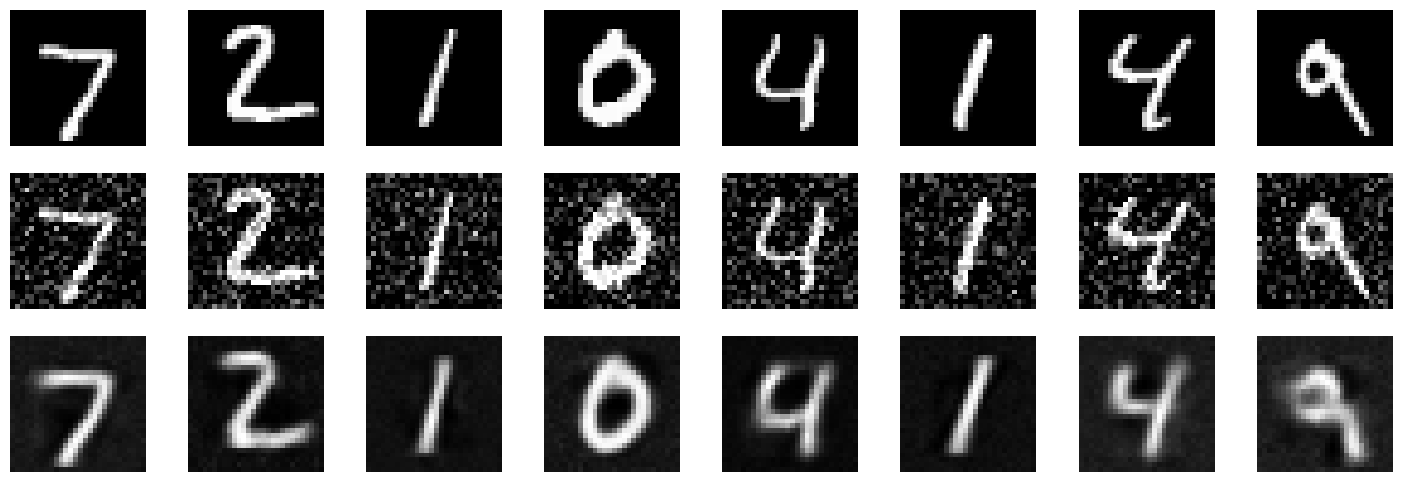

In [35]:
# Take 8 images from the test set, add noise and reconstruct
images, _ = next(iter(test_loader))
images = images[:8]

# Add Gaussian noise
noisy_images = add_gaussian_noise(images, std=sample_value(0.3, 0.1))
noisy_images = noisy_images.to(device)

# Reconstruct the images
model.eval()
with torch.no_grad():
    reconstructed, _, _ = model(noisy_images)
    # Plot original, noisy and reconstructed images
    fig, axes = plt.subplots(3, 8, figsize=(18, 6))
    for images, row in zip([images, noisy_images, reconstructed], axes):
        for img, ax in zip(images, row):
            img = img.to('cpu')
            ax.imshow(img.squeeze(), cmap='gray')
            ax.axis('off')
    plt.show()

Test on original reconstruction

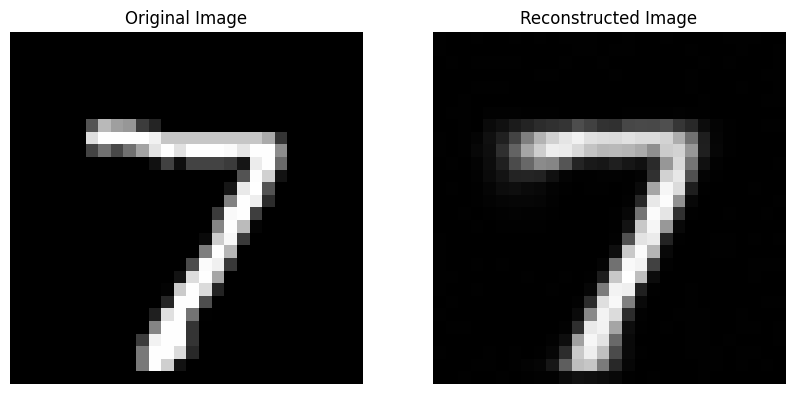

In [36]:
# Plot a single image and the reconstructed image
model.eval()
with torch.no_grad():
    single_image, _ = test_dataset[0]
    single_image = single_image.unsqueeze(0).to(device)  # Add batch dimension and move to device

    reconstructed, _, _ = model(single_image)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(single_image.cpu().view(28, 28), cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(reconstructed.cpu().view(28, 28), cmap='gray')
plt.title('Reconstructed Image')
plt.axis('off')
plt.show()


Still looking good

# Linear interpolation between two latent vectors

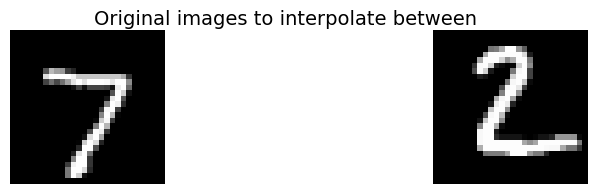

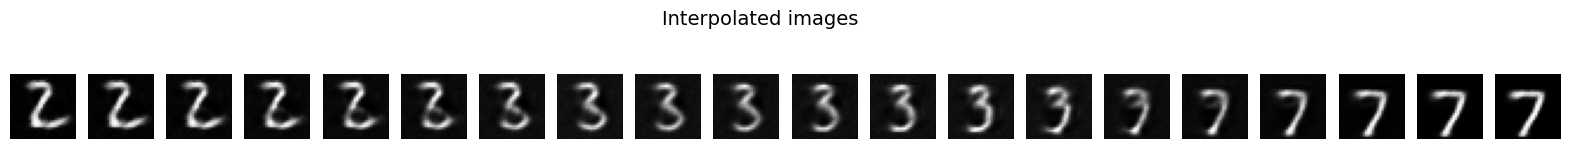

In [37]:
# Select two images from dataset
image1, _ = test_dataset[0]
image2, _ = test_dataset[1]

# Plot the two original images
fig, axes = plt.subplots(1, 2, figsize=(10, 2))
axes[0].imshow(image1.view(28, 28), cmap='gray')
axes[0].axis('off')
axes[1].imshow(image2.view(28, 28), cmap='gray')
axes[1].axis('off')
fig.suptitle("Original images to interpolate between", fontsize=14)
plt.show()

# Get the latent vectors of the images
model.eval()
with torch.no_grad():
    image1 = image1.unsqueeze(0).to(device)
    image2 = image2.unsqueeze(0).to(device)

    mean, log_var = model.encode(image1)
    z1 = model.reparameterization(mean, torch.exp(0.5 * log_var))

    mean, log_var = model.encode(image2)
    z2 = model.reparameterization(mean, torch.exp(0.5 * log_var))

    # Interpolate between the two latent vectors
    n_steps = 20
    latent_vectors = []
    for alpha in np.linspace(0, 1, n_steps):
        latent_vector = alpha * z1 + (1 - alpha) * z2 # Linear interpolation
        latent_vectors.append(latent_vector)

    latent_vectors = torch.cat(latent_vectors, dim=0)
    interpolated_images = model.decode(latent_vectors).cpu()

# Visualize the interpolated images
fig, axes = plt.subplots(1, n_steps, figsize=(20, 2))
for i in range(n_steps):
    axes[i].imshow(interpolated_images[i].view(28, 28), cmap='gray')
    axes[i].axis('off')
    fig.suptitle("Interpolated images", fontsize=14)
plt.show()


# Save model 'vae_model.pth'

In [38]:
# Save model
torch.save(model.state_dict(), "vae_model.pth")